# Estimate the uncertainties from repeats

## Author(s): Sven Buder (SB, WG4)

### History:
190215 SB Created

In [2]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import os
import sys
import collections
import glob
import scipy
import pickle
import pandas
import time

# Packages to work with FITS and (IDL) SME.out files
import astropy.io.fits as pyfits
import astropy.table as table
from astropy.table import Table, hstack, vstack, join
from scipy.io.idl import readsav

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.transforms import Bbox,TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

params = {
    'font.family'        : 'sans',
    'font.size'          : 17,
    'axes.labelsize'     : 20,
    'ytick.labelsize'    : 16,
    'xtick.labelsize'    : 16,
    'legend.fontsize'    : 20,
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

_parula_data = [[0.2081, 0.1663, 0.5292], 
                [0.2116238095, 0.1897809524, 0.5776761905], 
                [0.212252381, 0.2137714286, 0.6269714286], 
                [0.2081, 0.2386, 0.6770857143], 
                [0.1959047619, 0.2644571429, 0.7279], 
                [0.1707285714, 0.2919380952, 0.779247619], 
                [0.1252714286, 0.3242428571, 0.8302714286], 
                [0.0591333333, 0.3598333333, 0.8683333333], 
                [0.0116952381, 0.3875095238, 0.8819571429], 
                [0.0059571429, 0.4086142857, 0.8828428571], 
                [0.0165142857, 0.4266, 0.8786333333], 
                [0.032852381, 0.4430428571, 0.8719571429], 
                [0.0498142857, 0.4585714286, 0.8640571429], 
                [0.0629333333, 0.4736904762, 0.8554380952], 
                [0.0722666667, 0.4886666667, 0.8467], 
                [0.0779428571, 0.5039857143, 0.8383714286], 
                [0.079347619, 0.5200238095, 0.8311809524], 
                [0.0749428571, 0.5375428571, 0.8262714286], 
                [0.0640571429, 0.5569857143, 0.8239571429], 
                [0.0487714286, 0.5772238095, 0.8228285714], 
                [0.0343428571, 0.5965809524, 0.819852381], 
                [0.0265, 0.6137, 0.8135], 
                [0.0238904762, 0.6286619048, 0.8037619048], 
                [0.0230904762, 0.6417857143, 0.7912666667], 
                [0.0227714286, 0.6534857143, 0.7767571429], 
                [0.0266619048, 0.6641952381, 0.7607190476], 
                [0.0383714286, 0.6742714286, 0.743552381], 
                [0.0589714286, 0.6837571429, 0.7253857143], 
                [0.0843, 0.6928333333, 0.7061666667], 
                [0.1132952381, 0.7015, 0.6858571429], 
                [0.1452714286, 0.7097571429, 0.6646285714], 
                [0.1801333333, 0.7176571429, 0.6424333333], 
                [0.2178285714, 0.7250428571, 0.6192619048], 
                [0.2586428571, 0.7317142857, 0.5954285714], 
                [0.3021714286, 0.7376047619, 0.5711857143], 
                [0.3481666667, 0.7424333333, 0.5472666667], 
                [0.3952571429, 0.7459, 0.5244428571], 
                [0.4420095238, 0.7480809524, 0.5033142857], 
                [0.4871238095, 0.7490619048, 0.4839761905], 
                [0.5300285714, 0.7491142857, 0.4661142857], 
                [0.5708571429, 0.7485190476, 0.4493904762],
                [0.609852381, 0.7473142857, 0.4336857143], 
                [0.6473, 0.7456, 0.4188], 
                [0.6834190476, 0.7434761905, 0.4044333333], 
                [0.7184095238, 0.7411333333, 0.3904761905], 
                [0.7524857143, 0.7384, 0.3768142857], 
                [0.7858428571, 0.7355666667, 0.3632714286], 
                [0.8185047619, 0.7327333333, 0.3497904762], 
                [0.8506571429, 0.7299, 0.3360285714], 
                [0.8824333333, 0.7274333333, 0.3217], 
                [0.9139333333, 0.7257857143, 0.3062761905], 
                [0.9449571429, 0.7261142857, 0.2886428571], 
                [0.9738952381, 0.7313952381, 0.266647619], 
                [0.9937714286, 0.7454571429, 0.240347619], 
                [0.9990428571, 0.7653142857, 0.2164142857], 
                [0.9955333333, 0.7860571429, 0.196652381], 
                [0.988, 0.8066, 0.1793666667], 
                [0.9788571429, 0.8271428571, 0.1633142857], 
                [0.9697, 0.8481380952, 0.147452381], 
                [0.9625857143, 0.8705142857, 0.1309], 
                [0.9588714286, 0.8949, 0.1132428571], 
                [0.9598238095, 0.9218333333, 0.0948380952], 
                [0.9661, 0.9514428571, 0.0755333333], 
                [0.9763, 0.9831, 0.0538]]

parula = ListedColormap(_parula_data, name='parula')
parula_zero = _parula_data[0]
parula_0 = ListedColormap(_parula_data, name='parula_0')
parula_0.set_bad((1,1,1))
parula_r = ListedColormap(_parula_data[::-1], name='parula_r')

willi_blau = [0.0722666667, 0.4886666667, 0.8467]

In [4]:
data_idr3       = Table.read('/Users/buder/GALAH_DR3/data_products/GALAH_iDR3_combined_10k.fits',1)
data_abund_idr3 = Table.read('/Users/buder/GALAH_DR3/data_products/GALAH_iDR3_combined_10k_abund.fits',1)
data = join(data_idr3, data_abund_idr3)

# cut out all the stars that do not fulfill the quality criterion (including those with NaN values)
quality_cut = data['flag_sp'] <= 7
data = data[quality_cut]

In [ ]:
def plot_sme_errors(data, parameter = 'teff', cov_e_max = 100, e_max = 1000):

    kwargs_hist2d = dict(cmin=1, cmap=parula, rasterized=True)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    try:
        p,y,x,s1 = ax1.hist2d(
            data['snr_c2_iraf'],
            data['cov_e_'+parameter],
            bins = (
                np.linspace(0,150,100),
                np.linspace(0,cov_e_max,100)
                ),
            **kwargs_hist2d
        )
        c1 = plt.colorbar(s1, ax=ax1)
        c1.set_label('Nr. Spectra')
    except:
        ax1.text(0.5,0.5,'No values/column available',ha='center',va='center',transform=ax1.transAxes)
    ax1.set_xlabel('SNR CCD2')
    ax1.set_ylabel(r'SME covariance error '+parameter.replace('_','\_'))
    
    try:
        p,y,x,s2 = ax2.hist2d(
            data['snr_c2_iraf'],
            data['e_'+parameter],
            bins = (
                np.linspace(0,150,100),
                np.linspace(0,e_max,100)
                ),
            **kwargs_hist2d
        )
        c2 = plt.colorbar(s2, ax=ax2)
        c2.set_label('Nr. Spectra')
    except:
        ax2.text(0.5,0.5,'No values/column available',ha='center',va='center',transform=ax2.transAxes)
    ax2.set_xlabel('SNR CCD2')
    ax2.set_ylabel(r'SME 536 error '+parameter.replace('_','\_'))

    plt.tight_layout()

In [ ]:
plot_sme_errors(data, parameter = 'teff', cov_e_max = 75, e_max = 1000)
plt.savefig('../figures/SME_errors_teff.pdf',dpi=300,bbox_inches='tight')
plot_sme_errors(data, parameter = 'logg', cov_e_max = 1.0, e_max = 0.15)
plot_sme_errors(data, parameter = 'fe_h_atmo', cov_e_max = 0.15, e_max = 1.0)
plot_sme_errors(data, parameter = 'fe_h', cov_e_max = 0.2, e_max = 1.5)
#plot_sme_errors(data, parameter = 'vmic', cov_e_max = 1.0, e_max = 1.0)
plot_sme_errors(data, parameter = 'vbroad', cov_e_max = 1.0, e_max = 20.0)

In [16]:
def plot_sme_abundance_errors(data, parameter1 = 'Li', parameter2 = 'Cu5782', e_max1 = 0.5, e_max2 = 0.5):

    kwargs_hist2d = dict(cmin=1, cmap=parula, rasterized=True)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    try:
        p,y,x,s1 = ax1.hist2d(
            data['snr_c2_iraf'],
            data['cov_e_'+parameter1],
            bins = (
                np.linspace(0,150,100),
                np.linspace(0,e_max1,100)
                ),
            **kwargs_hist2d
        )
        c1 = plt.colorbar(s1, ax=ax1)
        c1.set_label('Nr. Spectra')
    except:
        ax1.text(0.5,0.5,'No values/column available',ha='center',va='center',transform=ax1.transAxes)
    ax1.set_xlabel('SNR CCD2')
    ax1.set_ylabel(r'SME covariance error '+parameter1.replace('_','\_'))
    
    try:
        p,y,x,s2 = ax2.hist2d(
            data['snr_c2_iraf'],
            data['cov_e_'+parameter2],
            bins = (
                np.linspace(0,150,100),
                np.linspace(0,e_max2,100)
                ),
            **kwargs_hist2d
        )
        c2 = plt.colorbar(s2, ax=ax2)
        c2.set_label('Nr. Spectra')
    except:
        ax2.text(0.5,0.5,'No values/column available',ha='center',va='center',transform=ax2.transAxes)
    ax2.set_xlabel('SNR CCD2')
    ax2.set_ylabel(r'SME covariance error '+parameter2.replace('_','\_'))

    plt.tight_layout()

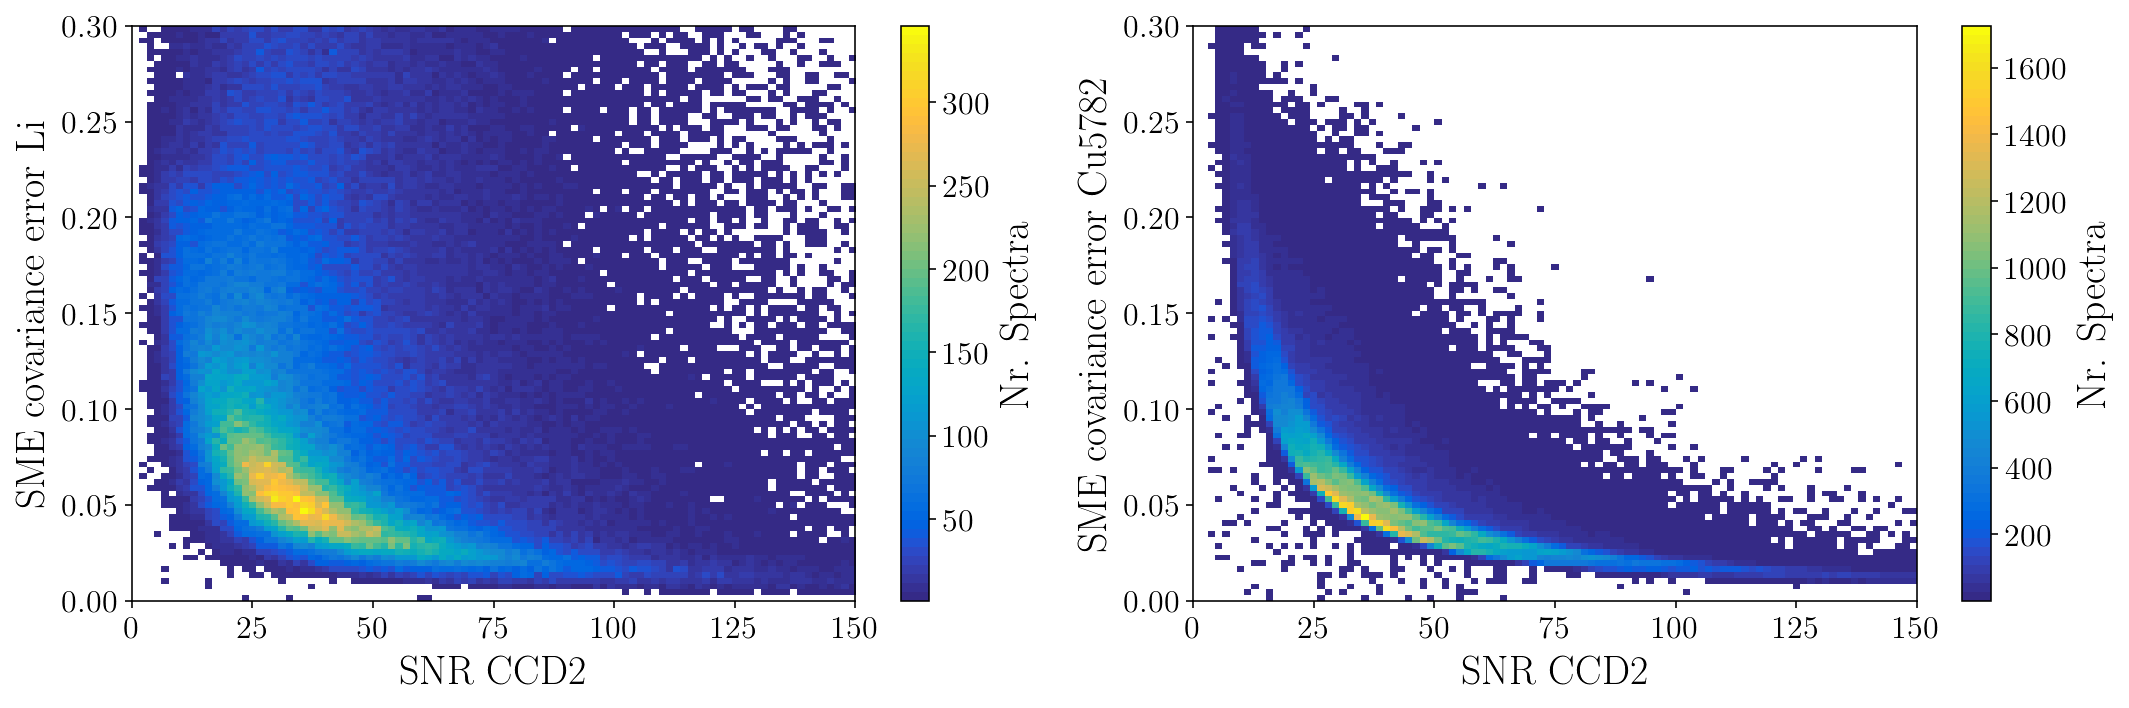

In [18]:
plot_sme_abundance_errors(data, parameter1 = 'Li', parameter2 = 'Cu5782', e_max1 = 0.3, e_max2 = 0.3)
plt.savefig('../figures/SME_errors_li_cu5782.pdf',dpi=300,bbox_inches='tight')

In [ ]:
start = time.time()

# Find all entries that appear multiple times
repeat_source_id = np.array([item for item, count in collections.Counter(data['source_id']).items() if count > 1])

# Take out the NaN value
repeat_source_id = repeat_source_id[repeat_source_id > 0]

print('Nr. of stars with repeat observations: '+str(len(repeat_source_id)))

end = time.time()
print('Computation took '+str("{:.1f}".format(end - start))+' sec')

In [ ]:
start = time.time()

mean_repeat_parameters = collections.OrderedDict()

signal_to_noise = ['snr_c2_iraf']
stellar_parameters = ['teff','logg','fe_h','vmic','vbroad']
abundance_parameters = ['Li_fe','MgI_fe','SiI_fe','CaI_fe']

for each_label in signal_to_noise:
    mean_repeat_parameters[each_label] = []
for each_label in stellar_parameters:
    mean_repeat_parameters[each_label] = []
for each_label in abundance_parameters:
    mean_repeat_parameters[each_label] = []

for each_repeat_source_id in repeat_source_id:
    repeat_index = np.where(each_repeat_source_id == data['source_id'])[0]
    
    # first estimate mean SNR values
    for each_label in signal_to_noise:
        mean_repeat_parameters[each_label].append(np.mean(data[each_label][repeat_index]))
        
        """
        NB: Still is not really what we want, 
        because a spectrum with SNR 100 and one with 10 
        would come here as 55, but we want the two spectra to
        usually have comparable SNR.
        
        Written email to Sanjib Sharma asking for script 
        of Fig. 15 of GALAH DR2 paper.
        """
        
    # second estimate mean stellar parameter values
    for each_label in stellar_parameters:
        mean_repeat_parameters[each_label].append(np.std(data[each_label][repeat_index]))

    # third estimate mean abundance values
    for each_label in abundance_parameters:
        
        mean_repeat_parameters[each_label].append(np.std(data[each_label][repeat_index]))

        """
        NB: We still have to incorporate that only those values with flag_X <= quality criterion are used
        """
    
for each_key in mean_repeat_parameters.keys():
    mean_repeat_parameters[each_key] = np.array(mean_repeat_parameters[each_key])

end = time.time()
print('Computation took '+str("{:.1f}".format(end - start))+' sec')

In [ ]:
a = -0.1*np.arange(500) + np.random.randint(0,5,500)
plt.scatter(np.arange(500),a)
func = scipy.interpolate.spline(np.arange(500),a,np.linspace(0,500,20))
plt.plot(np.linspace(0,500,20),func,c='r')

In [ ]:
snr_steps = np.linspace(0,150,30)

test = scipy.interpolate.spline(xk=mean_repeat_parameters['snr_c2_iraf'][:10], yk=mean_repeat_parameters['teff'][:10], xnew=snr_steps, order=2)

In [ ]:
test

In [ ]:
spline_function = collections.OrderedDict()

for each_key in mean_repeat_parameters.keys()[:2]:
    if each_key not in signal_to_noise:
        
        # We want to fit spline interpolations for each_key for a SNR from 0 to X
        snr_steps = np.linspace(0,150,30)
        
        spline_output = scipy.interpolate.spline(mean_repeat_parameters['snr_c2_iraf'], mean_repeat_parameters[each_key], snr_steps, order=3, kind='smoothest', conds=None)
        
        spline_function[each_key] = spline_output
        
        """
        Do we really want to use a 3rd-order spline?
        What would be the appropriate analytical form?
        
        cont1 * np.exp( - const2 * snr)?
        
        """

In [ ]:
kwargs_scatter = dict(s = 1, alpha = 0.5)

f, ax = plt.subplots(1, 3, figsize = (15,5))

for each_index, each_label in enumerate(['teff','logg','fe_h']):

    ax[each_index].scatter(
        mean_repeat_parameters['snr_c2_iraf'],
        mean_repeat_parameters[each_label],
        **kwargs_scatter
    )
    ax[each_index].set_xlim(0,100)
    if each_label == 'teff':
        ax[each_index].set_ylim(0,100)
    if each_label == 'logg':
        ax[each_index].set_ylim(0,0.03)
    if each_label == 'fe_h':
        ax[each_index].set_ylim(0,0.1)
